In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import keras
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

ROOT = '/kaggle/input/car-brand-classification-dataset'
DATA_DIR = os.path.join(ROOT, 'Car Brand Classification Dataset')
assert os.path.exists(DATA_DIR), f"DATA_DIR bulunamadı: {DATA_DIR}"
print('DATA_DIR:', DATA_DIR)

# Train/Val/Test dizinleri
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

2025-09-26 08:38:38.908583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758875919.158332      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758875919.244563      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
PyTorch version: 2.6.0+cu124
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
DATA_DIR: /kaggle/input/car-brand-classification-dataset/Car Brand Classification Dataset


In [2]:
# Sınıflar ve örnek sayıları (train dizinine göre)
classes = sorted([d for d in os.listdir(TRAIN_DIR)])
print('Train - Sınıf sayısı:', len(classes))


# Her sınıftaki görsel sayısı (train/val/test ayrı ayrı)
counts = []
for c in classes:
    cnt_train = len([f for f in os.listdir(os.path.join(TRAIN_DIR,c))])
    cnt_val = len([f for f in os.listdir(os.path.join(VAL_DIR,c))]) 
    cnt_test = len([f for f in os.listdir(os.path.join(TEST_DIR,c))])
    counts.append((c, cnt_train, cnt_val, cnt_test))


df_counts = pd.DataFrame(counts, columns=['brand','train_count','val_count','test_count']).sort_values('train_count', ascending=False)
print(df_counts.head(30))


# Toplam sayılar
print('Toplam train görsel sayısı:', df_counts['train_count'].sum())
print('Toplam val görsel sayısı:', df_counts['val_count'].sum())
print('Toplam test görsel sayısı:', df_counts['test_count'].sum())

Train - Sınıf sayısı: 33
            brand  train_count  val_count  test_count
0           Acura          349         75          75
1    Aston Martin          349         75          75
2            Audi          349         75          75
3             BMW          349         75          75
4         Bentley          349         75          75
5           Buick          349         75          75
6        Cadillac          349         75          75
7       Chevrolet          349         75          75
8        Chrysler          349         75          75
9           Dodge          349         75          75
10           FIAT          349         75          75
11           Ford          349         75          75
12            GMC          349         75          75
13          Honda          349         75          75
14        Hyundai          349         75          75
15       INFINITI          349         75          75
16         Jaguar          349         75          75
17 

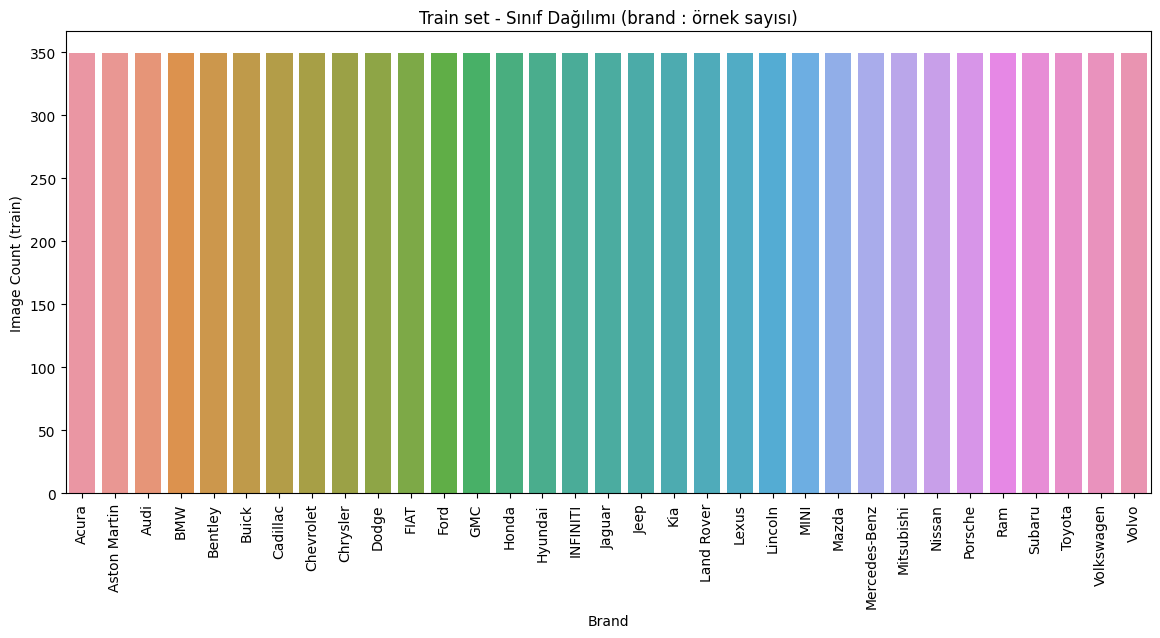

In [3]:
# Sınıf dağılımı görseli (train)
plt.figure(figsize=(14,6))
sns.barplot(data=df_counts, x='brand', y='train_count')
plt.xticks(rotation=90)
plt.title('Train set - Sınıf Dağılımı (brand : örnek sayısı)')
plt.xlabel('Brand')
plt.ylabel('Image Count (train)')
plt.show()

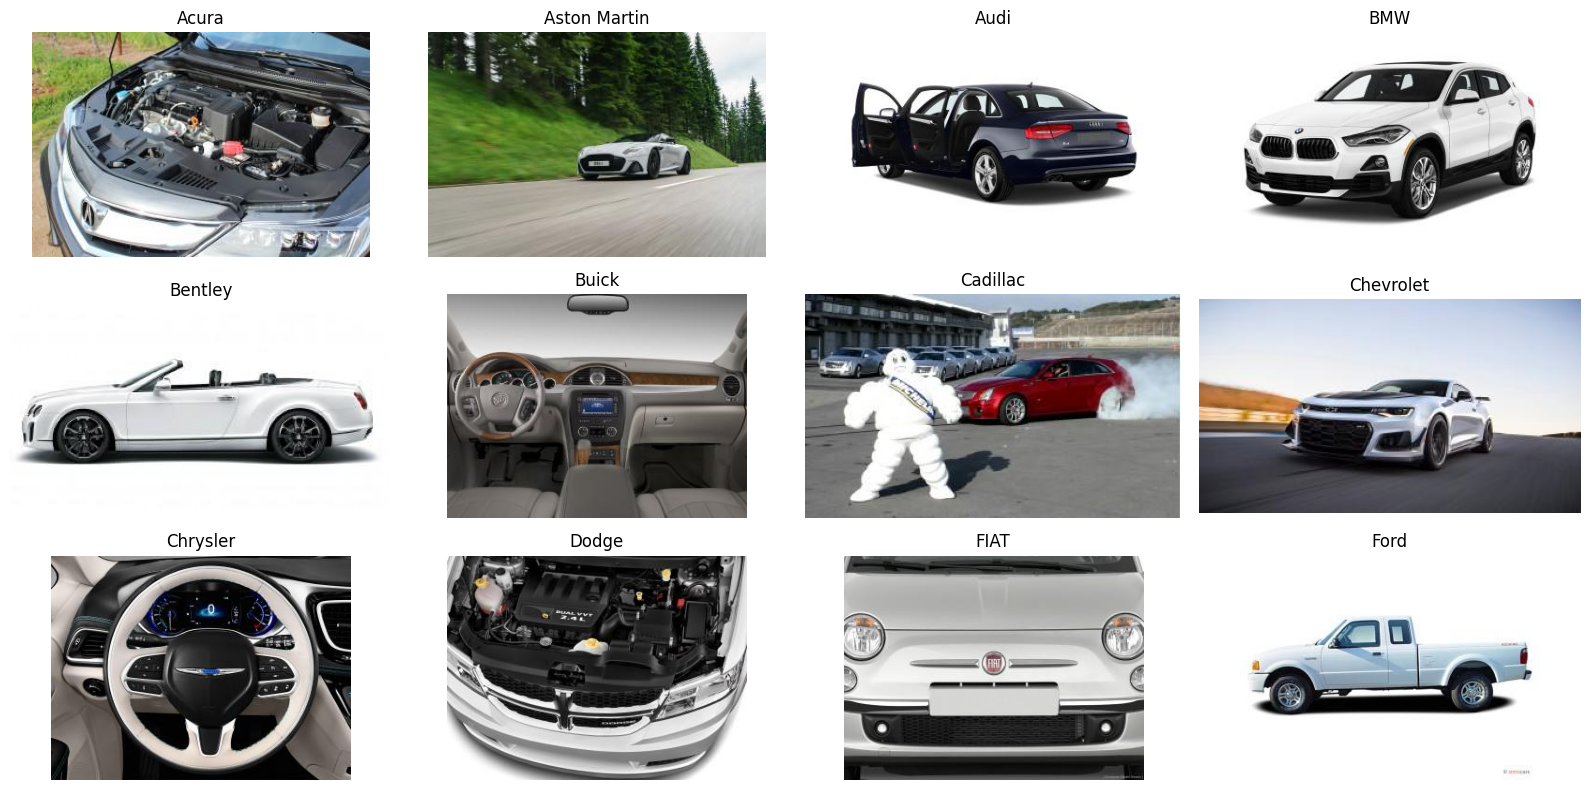

In [4]:
# Örnek görseller (train'den)
num_show = 12
sample_brands = df_counts['brand'].head(num_show).tolist()
plt.figure(figsize=(16,8))
for i, brand in enumerate(sample_brands):
    img_dir = os.path.join(TRAIN_DIR, brand)
    img_files = [f for f in os.listdir(img_dir)]
    if len(img_files)==0:
        continue
    img_path = os.path.join(img_dir, img_files[0])
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(brand)
    plt.axis('off')
plt.tight_layout()
plt.show()

Toplam okunan train görsel: 11517
Height min,max,mean,median: 50 696 229 240
Width  min,max,mean,median: 320 320 320 320


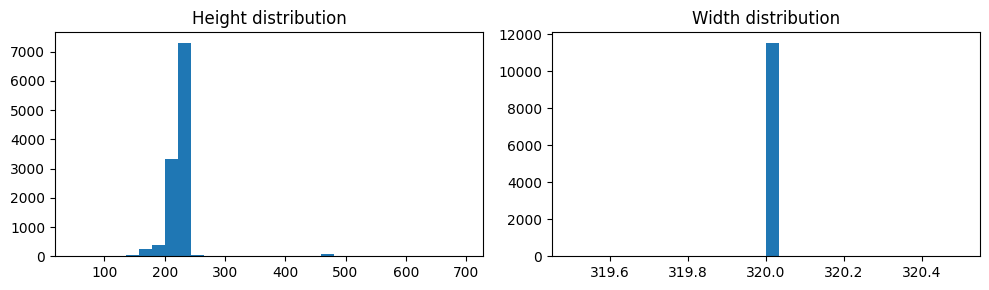

In [5]:
# Görsel boyut dağılımı (train)

# Eğer classes tanımlı değilse train dizininden al
if 'classes' not in globals():
    classes = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])

heights = []
widths = []
total = 0

for brand in classes:
    folder = os.path.join(TRAIN_DIR, brand)
    # güvenlik: klasör varsa devam et
    if not os.path.exists(folder):
        continue
    files = [f for f in os.listdir(folder)]
    for f in files:
        p = os.path.join(folder, f)
        img = cv2.imread(p)
        if img is None:
            continue
        h, w = img.shape[:2]
        heights.append(h)
        widths.append(w)
        total += 1

print("Toplam okunan train görsel:", total)
if total > 0:
    print("Height min,max,mean,median:", min(heights), max(heights), int(np.mean(heights)), int(np.median(heights)))
    print("Width  min,max,mean,median:",  min(widths),  max(widths),  int(np.mean(widths)), int(np.median(widths)))
else:
    print("Hiç görsel okunamadı. TRAIN_DIR ve classes kontrol et.")

# Histogram
if total > 0:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1); plt.hist(heights, bins=30); plt.title('Height distribution')
    plt.subplot(1,2,2); plt.hist(widths, bins=30); plt.title('Width distribution')
    plt.tight_layout(); plt.show()


In [6]:
### EDA Özeti
# Train_set: 33 sınıf, toplam 11517 görsel.
# Val_set: toplam 2475 görsel.
# Test_set: toplam 2475 görsel.
# Ortalama görsel boyutu: 229 x 320


In [7]:
# directory'den dataset oluşturma

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE
SEED       = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True, seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,   image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,  image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Sınıf sayısı:", num_classes)


Found 11517 files belonging to 33 classes.
Found 2475 files belonging to 33 classes.
Found 2475 files belonging to 33 classes.
Sınıf sayısı: 33


In [8]:
# ImageDataGenerator: augmentation (train) + sadece rescale (val/test)

train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,          # normalize (0-255 -> 0-1)
    rotation_range=10,       # rotation
    width_shift_range=0.08,  # küçük kaydırma
    height_shift_range=0.08,
    zoom_range=0.08,         # zoom
    horizontal_flip=True,    # flip (yansıtma)
    brightness_range=(0.9, 1.1)  # basit bir "color jitter" etkisi :D
)

# val/test için augmentation YOK; sadece normalize
eval_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


In [9]:
# flow_from_directory: etiketleri klasör adından otomatik alır, one-hot üretir (categorical)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # -> one-hot (etiketleme)
    shuffle=True
)

#flow_from_directory dataset bozuk görsel içeriyorsa yükleyemediğinden aslında bir nevi temizlik yapmakta
class_indices = train_gen.class_indices  # {'Audi':0, 'BMW':1, ...}
idx_to_class = {v:k for k,v in class_indices.items()}
cls_list      = list(class_indices.keys())           # SIRAYI sabitlemek için
print("Sınıf sayısı:", len(class_indices))
print("Örnek eşleşmeler:", list(class_indices.items())[:10])

val_gen = eval_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=cls_list
)

test_gen = eval_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=cls_list
)





Found 11517 images belonging to 33 classes.
Sınıf sayısı: 33
Örnek eşleşmeler: [('Acura', 0), ('Aston Martin', 1), ('Audi', 2), ('BMW', 3), ('Bentley', 4), ('Buick', 5), ('Cadillac', 6), ('Chevrolet', 7), ('Chrysler', 8), ('Dodge', 9)]
Found 2475 images belonging to 33 classes.
Found 2475 images belonging to 33 classes.


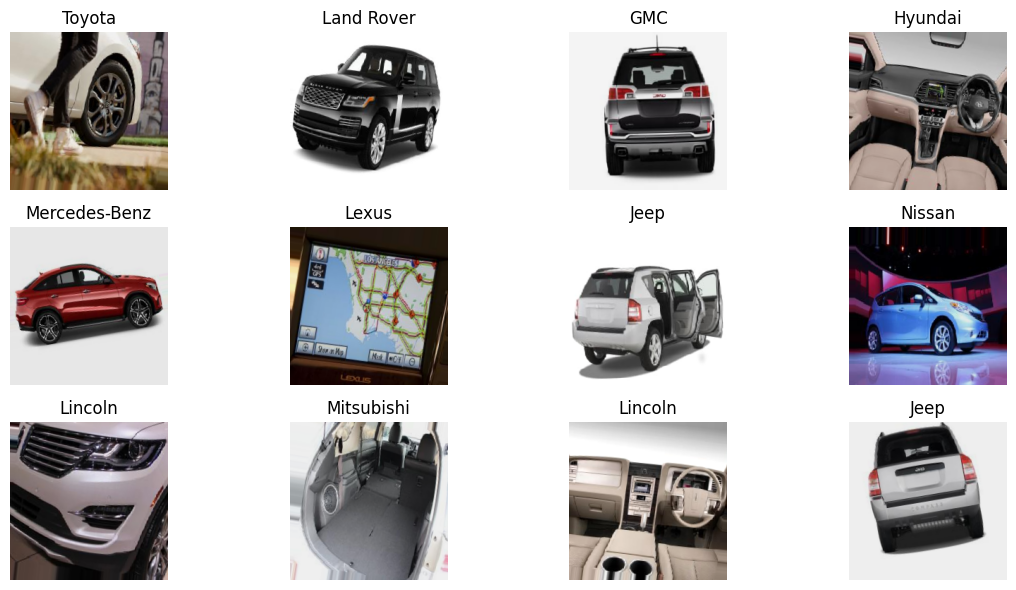

Batch shape: (32, 224, 224, 3) (32, 33)


In [10]:
# örnek batch görselleştirme
images, labels = next(train_gen)  # bir batch
plt.figure(figsize=(12,6))
for i in range(min(12, images.shape[0])):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images[i])
    cls_id = int(np.argmax(labels[i]))
    plt.title(idx_to_class[cls_id])   # sadece marka adı
    plt.axis('off')
plt.tight_layout(); plt.show()

print("Batch shape:", images.shape, labels.shape)  # (B, 224, 224, 3) ve (B, num_classes)


In [10]:
#Temel CNN modeli
INPUT_SHAPE = (224, 224, 3)  # 224x224 renkli resimler
num_classes = len(train_gen.class_indices)
INPUT_SHAPE = (224, 224, 3)

def create_cnn_model(input_shape=INPUT_SHAPE, n_classes=num_classes):
    model = keras.Sequential([
        layers.Conv2D(32,3,activation='relu',padding='same',input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32,3,activation='relu',padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.10),

        layers.Conv2D(64,3,activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64,3,activation='relu',padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.20),

        layers.Conv2D(128,3,activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128,3,activation='relu',padding='same'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.30),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.40),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

cnn_model = create_cnn_model()
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
from tensorflow.keras import callbacks
import time, math

EPOCHS = 100

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True) # val. kaybı iyileşmezse durur, en iyi ağırlıkları geri yükler.
reduce_lr      = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5) # öğrenme oranını düşürür
checkpt        = callbacks.ModelCheckpoint('/kaggle/working/cnn_best.h5', monitor='val_loss', save_best_only=True) # en iyi modeli kaydeder


start_time = time.time()
history = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr, checkpt],
    verbose=1
)
print(f"Eğitim süresi: {time.time() - start_time:.2f} sn")


Epoch 1/100


I0000 00:00:1758821880.752683     106 service.cc:148] XLA service 0x782ad8009b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758821880.754488     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758821880.754512     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758821881.474197     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/360 ━━━━━━━━━━━━━━━━━━━━ 2:14:10 22s/step - accuracy: 0.0312 - loss: 4.4786

I0000 00:00:1758821897.187098     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 ━━━━━━━━━━━━━━━━━━━━ 208s 516ms/step - accuracy: 0.0319 - loss: 3.7792 - val_accuracy: 0.0485 - val_loss: 3.4920 - learning_rate: 0.0010
Epoch 2/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 157s 435ms/step - accuracy: 0.0481 - loss: 3.5899 - val_accuracy: 0.0570 - val_loss: 3.4513 - learning_rate: 0.0010
Epoch 3/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 156s 432ms/step - accuracy: 0.0556 - loss: 3.5041 - val_accuracy: 0.0497 - val_loss: 3.4839 - learning_rate: 0.0010
Epoch 4/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 156s 432ms/step - accuracy: 0.0619 - loss: 3.4434 - val_accuracy: 0.0634 - val_loss: 3.4382 - learning_rate: 0.0010
Epoch 5/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 156s 433ms/step - accuracy: 0.0788 - loss: 3.3848 - val_accuracy: 0.0929 - val_loss: 3.3679 - learning_rate: 0.0010
Epoch 6/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 154s 428ms/step - accuracy: 0.0785 - loss: 3.3640 - val_accuracy: 0.0622 - val_loss: 3.5904 - learning_rate: 0.0010
Epoch 7/100
360/360 ━━━━━━━━━━━━━━━━━━━━ 155s 431ms/step - accuracy: 0

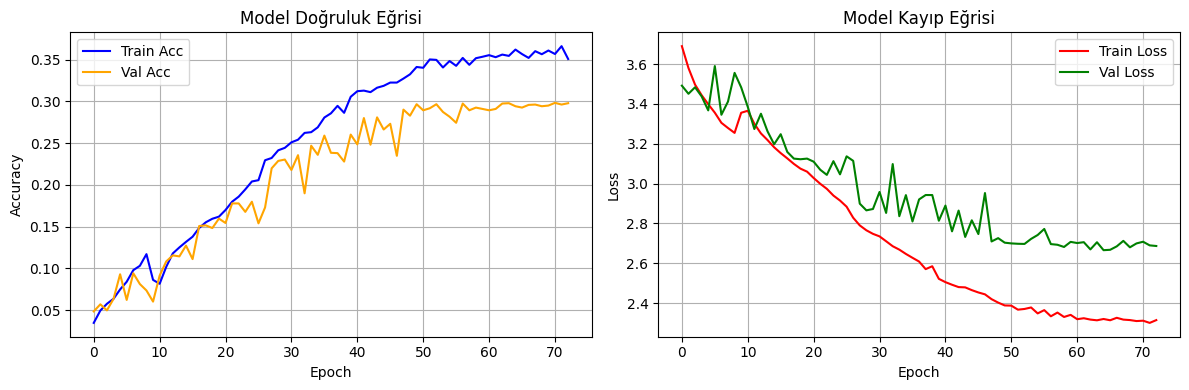

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='orange')
plt.title('Model Doğruluk Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='green')
plt.title('Model Kayıp Eğrisi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Test Kaybı: 2.6637
Test Doğruluğu: 0.3127

Sınıflandırma Raporu:
               precision    recall  f1-score   support

        Acura     0.4043    0.2533    0.3115        75
 Aston Martin     0.3534    0.5467    0.4293        75
         Audi     0.2296    0.4133    0.2952        75
          BMW     0.2432    0.1200    0.1607        75
      Bentley     0.1985    0.3467    0.2524        75
        Buick     0.2667    0.3200    0.2909        75
     Cadillac     0.2547    0.3600    0.2983        75
    Chevrolet     0.2727    0.1200    0.1667        75
     Chrysler     0.4535    0.5200    0.4845        75
        Dodge     0.2745    0.1867    0.2222        75
         FIAT     0.5595    0.6267    0.5912        75
         Ford     0.2069    0.0800    0.1154        75
          GMC     0.3287    0.6267    0.4312        75
        Honda     0.1500    0.0400    0.0632        75
      Hyundai     0.1818    0.0533    0.0825        75
     INFINITI     0.3627    0.4933    0.4181        75

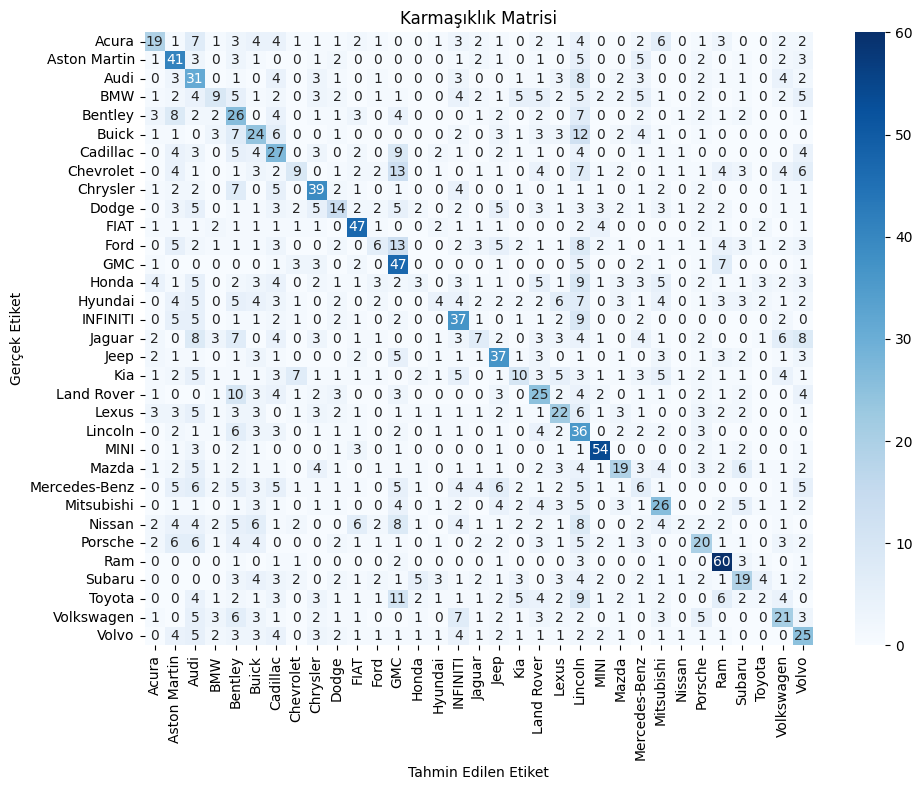

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step


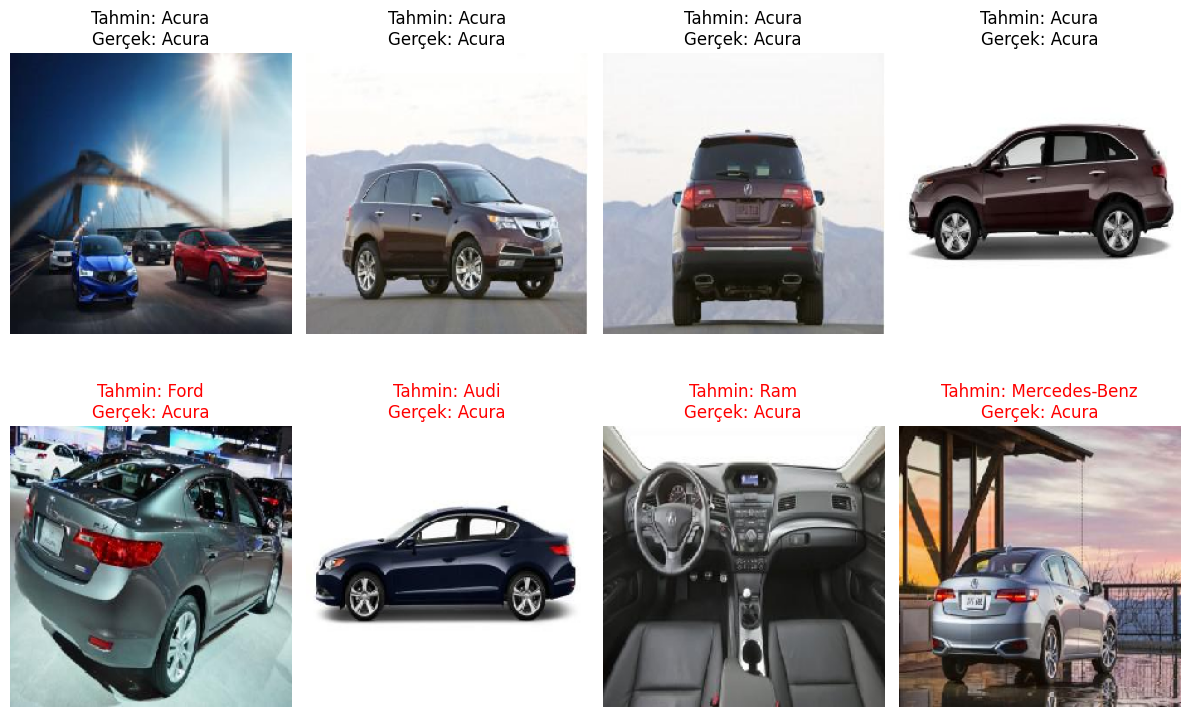

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1) Test setinde kayıp ve doğruluk
test_loss, test_acc = cnn_model.evaluate(test_gen, verbose=0)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_acc:.4f}")

# 2) Tahminler
y_prob = cnn_model.predict(test_gen, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_gen.classes

# class_names listesi (sıralı)
idx_to_class = {v:k for k,v in train_gen.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# 3) Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# 4) Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.tight_layout()
plt.show()

# 5) Doğru ve yanlış tahminlerden görselleştirme
# test_gen'den bir batch çekelim
X_batch, y_batch = next(test_gen)
y_true_b = np.argmax(y_batch, axis=1)
y_pred_b = np.argmax(cnn_model.predict(X_batch), axis=1)

correct_idx = np.where(y_pred_b == y_true_b)[0]
wrong_idx   = np.where(y_pred_b != y_true_b)[0]

plt.figure(figsize=(12,8))

# Doğru tahmin örnekleri
for i, idx in enumerate(correct_idx[:4]):
    plt.subplot(2,4,i+1)
    plt.imshow(X_batch[idx])
    plt.title(f"Tahmin: {class_names[y_pred_b[idx]]}\nGerçek: {class_names[y_true_b[idx]]}")
    plt.axis('off')

# Yanlış tahmin örnekleri
for i, idx in enumerate(wrong_idx[:4]):
    plt.subplot(2,4,i+5)
    plt.imshow(X_batch[idx])
    plt.title(f"Tahmin: {class_names[y_pred_b[idx]]}\nGerçek: {class_names[y_true_b[idx]]}", color='red')
    plt.axis('off')

plt.tight_layout()
plt.show()


Model: "vgg16_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rgb_0_1 (InputLayer)            │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16_preprocess (Lambda)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 33)             │         8,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,854,497 (56.67 MB)

 Trainable params: 139,809 (546.13 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 214s 583ms/step - accuracy: 0.0333 - loss: 7.2844 - val_accuracy: 0.0671 - val_loss: 3.4793 - learning_rate: 3.0000e-04
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 184s 510ms/step - accuracy: 0.0493 - loss: 3.4810 - val_accuracy: 0.0913 - val_loss: 3.3752 - learning_rate: 3.0000e-04
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 177s 491ms/step - accuracy: 0.0709 - loss: 3.4068 - val_accuracy: 0.1172 - val_loss: 3.2874 - learning_rate: 3.0000e-04
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 168s 467ms/step - accuracy: 0.0888 - loss: 3.3307 - val_accuracy: 0.1329 - val_loss: 3.1958 - learning_rate: 3.0000e-04
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 168s 465ms/step - accuracy: 0.1051 - loss: 3.2664 - val_accuracy: 0.1531 - val_loss: 3.1357 - learning_rate: 3.0000e-04
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 168s 466ms/step - accuracy: 0.1199 - loss: 3.1965 - val_accuracy: 0.1657 - val_loss: 3.0463 - learning_rate: 3.0000e-04
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 

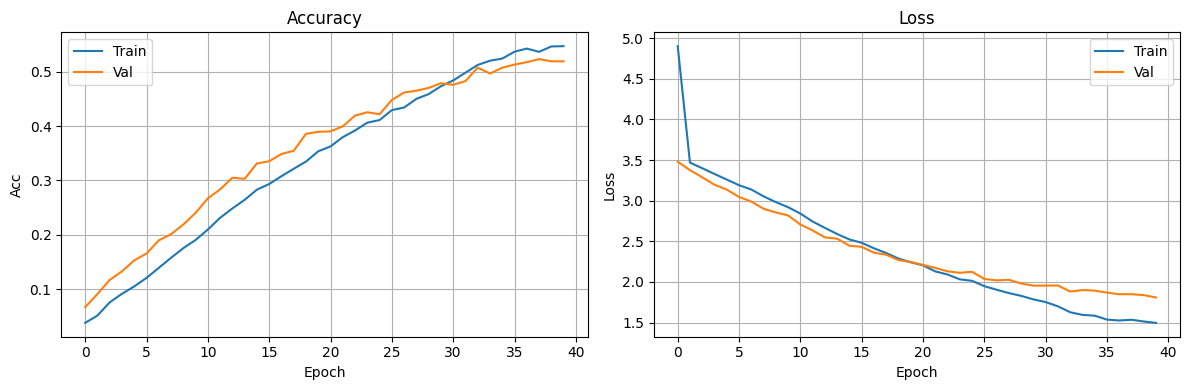

In [16]:
# VGG16 TRANSFER LEARNING (flow_from_directory jeneratörleri ile)
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
import numpy as np

# Sınıf isimleri
INPUT_SHAPE = (224, 224, 3)                             # generator target_size ile uyumlu
num_classes = len(train_gen.class_indices)
idx_to_class = {v:k for k,v in train_gen.class_indices.items()}
class_names = [idx_to_class[i] for i in range(num_classes)]

# Önceden eğitilmiş VGG16 (tepe yok)
base_model = keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)
base_model.trainable = False   # önce tamamen dondur

# [0,1] -> VGG16 preprocess (mean subtraction, channel handling)
def vgg16_preproc(x):
    x = x * 255.0 #görsellerin piksel değerlerini hatırlarsanız imagedatagenerator ile 0-1 aralığına çekmiştik.
                  #Fakat vgg16 nın giriş formatı 0-255
    return keras.applications.vgg16.preprocess_input(x) #rgb kanallarını bgr ye çeviriyor yine üstteki sebepten dolayı (vgg16 eğitimi)

# Model başı (GAP + Dense)
inp = keras.Input(shape=INPUT_SHAPE, name='rgb_0_1')
x = layers.Lambda(vgg16_preproc, name='vgg16_preprocess')(inp)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inp, out, name='vgg16_transfer')
model.summary()

# Derleme (baş eğitimi)
model.compile(optimizer=keras.optimizers.Adam(3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cbs_head = [
    callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    callbacks.ModelCheckpoint('/kaggle/working/vgg16_head_best.h5', monitor='val_loss', save_best_only=True),
]

# Baş eğitimi
history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,                    
    callbacks=cbs_head,
    verbose=1
)

# Fine-Tune: sadece block5 katmanlarını aç (düşük LR ile) // block5 daha özel özellikleri olduğu için diğer blocklara göre onu kullandık
for layer in base_model.layers:
    layer.trainable = layer.name.startswith('block5')

model.compile(optimizer=keras.optimizers.Adam(1e-5),   # FT için düşük LR şart
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cbs_ft = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    callbacks.ModelCheckpoint('/kaggle/working/vgg16_ft_best.h5', monitor='val_loss', save_best_only=True),
]

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,                     
    callbacks=cbs_ft,
    verbose=1
)

# 6) Test değerlendirme
test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"\n[VGG16-Transfer] Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

# 7) Eğitim grafikleri (head + FT birleşik)
hist = {k:list(v) for k,v in history_head.history.items()}
for k,v in history_ft.history.items():
    hist[k] = hist.get(k, []) + list(v)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist['accuracy'], label='Train'); plt.plot(hist['val_accuracy'], label='Val')
plt.title('Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Acc'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(hist['loss'], label='Train'); plt.plot(hist['val_loss'], label='Val')
plt.title('Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()



Adam ile eğitim...


I0000 00:00:1758876070.163733      97 service.cc:148] XLA service 0x7f8950006430 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758876070.164681      97 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758876070.164707      97 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758876070.942206      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758876088.204532      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Adam Test Doğruluğu: 0.0966

RMSprop ile eğitim...
RMSprop Test Doğruluğu: 0.1297

SGD ile eğitim...
SGD Test Doğruluğu: 0.0954


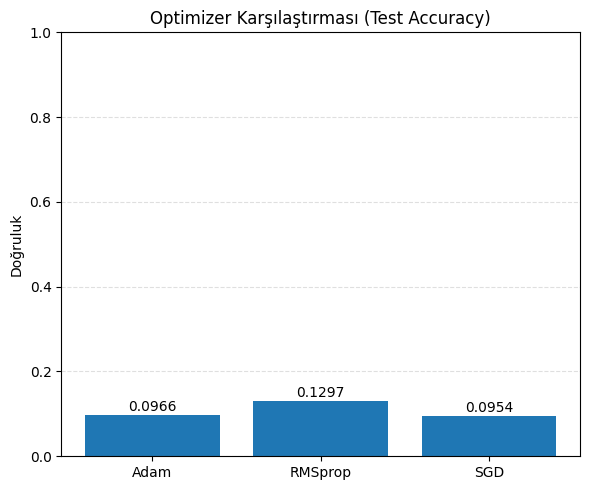

In [11]:
#Optimizatör Karşılaştırması
# Aynı mimariyi farklı optimizatörlerle (Adam, RMSprop, SGD+momentum vb.) kısa eğitip **test doğruluklarını** kıyaslıyoruz.
optimizers = {
    'Adam':    keras.optimizers.Adam(1e-3),
    'RMSprop': keras.optimizers.RMSprop(1e-3),
    'SGD':     keras.optimizers.SGD(1e-2, momentum=0.9)
}

results = {}
EPOCHS = 10  # kısa tuttuk

for name, opt in optimizers.items():
    print(f"\n{name} ile eğitim...")
    model = create_cnn_model(input_shape=train_gen.image_shape, n_classes=len(train_gen.class_indices))
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    hist = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS, verbose=0)
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    results[name] = float(test_acc)
    print(f"{name} Test Doğruluğu: {test_acc:.4f}")

# Bar grafik
plt.figure(figsize=(6,5))
bars = plt.bar(list(results.keys()), list(results.values()))
plt.title('Optimizer Karşılaştırması (Test Accuracy)')
plt.ylabel('Doğruluk'); plt.ylim(0,1)
for b, v in zip(bars, results.values()):
    plt.text(b.get_x()+b.get_width()/2, v+0.01, f"{v:.4f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout(); plt.show()